In [1]:
%load_ext autoreload
%autoreload 2

from src.util import load_coauthor_nx, ddir, fn_nodes, fn_statoids
import community
import networkx as nx
from operator import itemgetter
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
(G, nodes) = load_coauthor_nx() # abstracted into src

N nodes 361 ; N not nodes: 368
Proportion who did not coauthor 50.48010973936899
Name: 
Type: Graph
Number of nodes: 361
Number of edges: 463
Average degree:   2.5651


## Communities

In [3]:
nodes_df = pd.read_csv(fn_nodes)
statoids = pd.read_csv(fn_statoids)
statoids = area_dict = dict(zip(statoids.DL, statoids.Country))

fn_spp = ddir + '2019-05-23-Apoidea world consensus file Sorted by name 2019 describers_2.0-denormalised.csv'
spp = pd.read_csv(fn_spp)[["idx", "full.name.of.describer.n"]]
spp = spp[spp.duplicated(subset="idx", keep=False)] # keep only those with >1 authors

In [4]:
communities = community.best_partition(G)  # https://python-louvain.readthedocs.io/en/latest/api.html
nx.set_node_attributes(G, communities, 'modularity')

class0 = [n for n in G.nodes() if G.nodes[n]['modularity'] == 0]; len(class0)

# Then create a dictionary of the eigenvector centralities of those nodes
class0_eigenvector = {n:G.nodes[n]['eigenvector'] for n in class0}

# Then sort that dictionary and print the first 5 results
class0_sorted_by_eigenvector = sorted(class0_eigenvector.items(), key=itemgetter(1), reverse=True)
print("Modularity Class 0 Sorted by Eigenvector Centrality:")
for node in class0_sorted_by_eigenvector[:10]:
    print("Name:", node[0], "| Eigenvector Centrality:", node[1])

Modularity Class 0 Sorted by Eigenvector Centrality:
Name: Michael Scott Engel | Eigenvector Centrality: 0.4607013143210458
Name: Terry L. Griswold | Eigenvector Centrality: 0.32146051380748536
Name: Victor Hugo Gonzalez [Betancourt] | Eigenvector Centrality: 0.29420394689460644
Name: Ricardo Ayala Barajas | Eigenvector Centrality: 0.19620102130148936
Name: Ismael Alejandro Hinojosa-Díaz | Eigenvector Centrality: 0.1845644245423236
Name: John Stoskopf Ascher | Eigenvector Centrality: 0.1697520309963212
Name: Molly Greer Rightmyer | Eigenvector Centrality: 0.14119439831030106
Name: Mark Amidon Deyrup | Eigenvector Centrality: 0.12334089443215683
Name: Allan Henry Smith-Pardo | Eigenvector Centrality: 0.10826750398308012
Name: Abdulaziz S. Alqarni | Eigenvector Centrality: 0.1074778533950178


In [26]:
modularity = {}                            # Create a new, empty dictionary

for k, v in communities.items():           # Loop through the community dictionary
    if v not in modularity:
        modularity[v] = [k]                # Add a new key for a modularity class the code hasn't seen before
    else:
        modularity[v].append(k)            # Append a name to the list for a modularity class the code has already seen

countries = {}
counter = 0
for k, v in modularity.items():            # Loop through the new dictionary
    counter = counter + len(v)
    country_li = []
    for i in range(0, len(v)):
        country = nodes_df[nodes_df['full.name.of.describer.n'] == v[i]]['residence.country.describer.n'].values[0]
        country = str.split(country, "; ")
        country_li = country_li + country
    countries[k] = Counter(country_li)

print("\n", counter, " authors/ nodes")


 361  authors/ nodes


In [27]:
len(modularity)-41 # includes  subgraphs which are N=42

12

In [28]:
subgraphs = [c for c in sorted(nx.connected_components(G), key=len, reverse=True)]

def get_subgraph(node_name):
    subgraph_idx = -1
    
    for i in range(0, len(subgraphs)):
        if (node_name in list(subgraphs[i])):
            subgraph_idx = i
    
    return subgraph_idx
          
community_subgraph = pd.DataFrame.from_dict({key:get_subgraph(value[0]) for (key,value) in modularity.items()}, orient='index')

In [29]:
len(modularity)

53

In [9]:
spp.columns

Index(['idx', 'full.name.of.describer.n'], dtype='object')

In [30]:
N_species = {}
for i, sg in enumerate(modularity.items()):
    spp_li = []
    for auth in sg[1]:
        spp_li = spp_li + list(spp[spp['full.name.of.describer.n']==auth]['idx'].values)
        
    N_species[i] = len(set(spp_li))
N_species = pd.DataFrame.from_dict(N_species, orient="index")
N_species.columns = ["N_species"]

In [31]:
countries_df = pd.DataFrame.from_dict(countries, orient='index')
cols = list(countries_df.columns.values) 
cols.pop(cols.index('[unknown]'))
cols_rearranged = cols + ['[unknown]']
countries_df = countries_df[cols_rearranged]
countries_df = countries_df.sort_index()

In [34]:
countries_summary = countries_df.stack().reset_index()

# count number of countries, count number of taxonomist
countries_summary = countries_summary.groupby("level_0").agg({0: ['count', 'sum']})
countries_summary = countries_summary.merge(community_subgraph, "outer", left_index=True, right_index=True)
countries_summary = countries_summary.merge(N_species, "outer", left_index=True, right_index=True)

countries_summary.columns = ['N_countries', 'N_taxonomist', 'Subgraph_id', 'N_species']
countries_summary.index.names = ['Modules']
countries_summary = countries_summary.sort_values(['Subgraph_id', 'N_taxonomist'], ascending=[True,  False])
countries_summary['idx'] = range(0, len(countries_summary))
countries['lab'] = ' [' + countries_summary['N_taxonomist'].astype(int).astype(str) + ',' +\
    countries_summary['N_countries'].astype(int).astype(str) + "," +\
    countries_summary['N_species'].astype(int).astype(str) + '] ' +\
    "id" + countries_summary.idx.astype(str).str.pad(2, "left", "0") + " / " +\
    "S" + countries_summary['Subgraph_id'].astype(str).str.pad(2, "left", "0")
    
countries_summary = countries_summary.sort_index()
idx = countries_summary.idx.values
countries_summary = countries_summary.sort_values(['Subgraph_id', 'N_taxonomist'], ascending=[True,  False])

In [35]:
countries_summary.size

265

In [36]:
countries_summary.agg({'N_countries': ['median', 'min', 'max'],
                       'N_taxonomist': ['median', 'min', 'max']})

,N_countries,N_taxonomist
median,1.0,2.0
min,1.0,2.0
max,12.0,45.0


In [37]:
countries_summary.groupby('Subgraph_id')\
                 .agg({'N_countries': ['median', 'min', 'max', 'count'],
                       'N_taxonomist': ['median', 'min', 'max']}).iloc[0] # for subgraph 1

N_countries   median     7.0
              min        2.0
              max       12.0
              count     12.0
N_taxonomist  median    18.5
              min        2.0
              max       45.0
Name: 0, dtype: float64

All of the subgraphs only have one cluster, but the largest one has 12 clusters.

In [38]:
countries_prop = countries_df.apply(lambda r: round(r/r.sum()*100, 1), axis=1)
countries_prop.index = idx
countries_prop = countries_prop.sort_index()
countries_prop.index = countries['lab']

In [39]:
def parse_countries(country):
    if country == "[unknown]":
        return country
    else:
        return statoids[country]
countries_prop.columns = [parse_countries(x) for x in countries_prop.columns]
countries_prop.columns = countries_prop.columns + " [" + countries_prop.count().astype(str) + "]"

[Text(113.99999999999999, 0.5, 'Countries'),
 Text(0.5, 96.0, '\nProportion of country from each module (%)')]

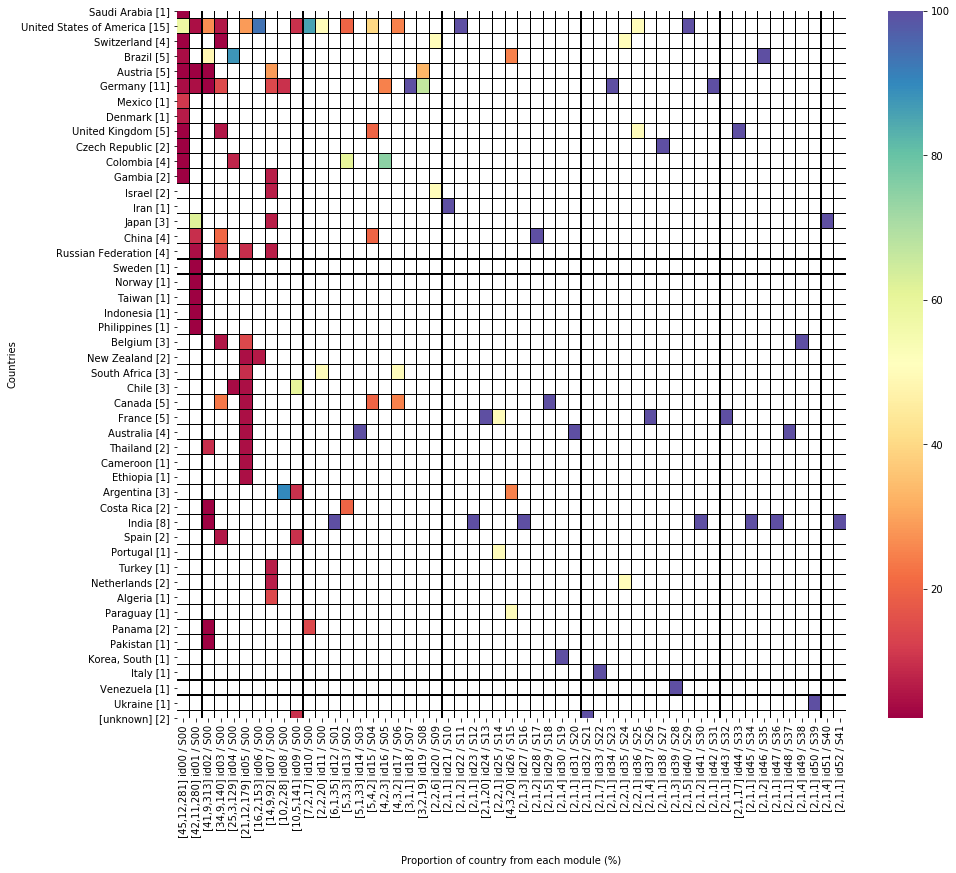

In [40]:
countries_prop_t = countries_prop.transpose()
plt.figure(figsize=(15, 13))
ax = sns.heatmap(countries_prop_t, cmap=plt.get_cmap("Spectral"), linecolor="k", linewidths=0.1)
ax.set(xlabel='\nProportion of country from each module (%)', ylabel='Countries')

In [19]:
countries_prop.iloc[2][countries_prop.iloc[2].notna()]

United States of America [15]    26.8
Brazil [5]                       48.8
Austria [5]                       2.4
Germany [11]                      2.4
Thailand [2]                      9.8
Costa Rica [2]                    2.4
India [8]                         2.4
Panama [2]                        2.4
Pakistan [1]                      2.4
Name:  [41,9] id02 / S00, dtype: float64

In [20]:
countries_prop.iloc[9][countries_prop.iloc[9].notna()]

United States of America [15]    10.0
Chile [3]                        60.0
Argentina [3]                    10.0
Spain [2]                        10.0
[unknown] [2]                    10.0
Name:  [10,5] id09 / S00, dtype: float64